# Extended demo of glm_utils

In [1]:
from glm_utils.preprocessing import time_delay_embedding, BasisProjection
from glm_utils.bases import raised_cosine, multifeature_basis
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model as lm
import scipy.signal
from demo_utils import get_data
plt.style.use('ncb.mplstyle')

## Get data
In this demo we will work with a response (y) which has been constructed from normalized randomly generated feature (x, 4 inputs) that were filtered with known filters, one for each features.

`Explain what kind of model are we trying to create here: multi-feature model predicting one variable.`

x: (100000, 4), y: (100000,), filters (50, 4)


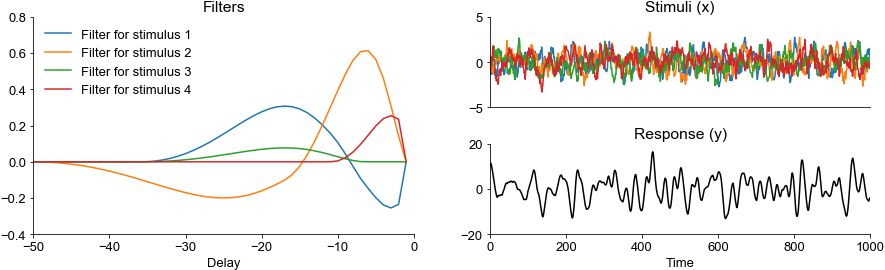

In [3]:
x, y, filters = get_data(npoints = 100_000)

nb_points, nb_stim = x.shape
filter_duration = filters.shape[0]
T = np.arange(-filter_duration, 0)

print(f"x: {x.shape}, y: {y.shape}, filters {filters.shape}")
plt.figure(figsize=[15,4])
plt.subplot(121)
plt.plot(T, filters)
plt.title('Filters')
plt.xlabel('Delay')
plt.legend([f'Filter for stimulus {f}' for f in range(1,5)])

plt.subplot(222)
plt.plot(x[:1000])
plt.title('Stimuli (x)')
plt.xticks(())

plt.subplot(224)
plt.plot(y[:1000], c='k')
plt.title('Response (y)')
plt.xlabel('Time')
plt.subplots_adjust(hspace=0.4)
plt.show()

## Normalize the data

`I know this doesn't do anything since our data are already normalized but may be good just for completeness. Why normalize? How?`


## Time-delay-embedding

We collect the history of our stimulus `x` using Time-delay-embedding (see [basics](basics.ipynb)).

In [4]:
Xmulti, ymulti = time_delay_embedding(x, y, window_size=filter_duration, flatten_inside_window=True)
print(f"Xmulti: {Xmulti.shape}, ymulti: {ymulti.shape}")

Xmulti: (99950, 200), ymulti: (99950,)


## Define a basis

The next step is to define our basis function (for more see [basics](basics.ipynb)).

Our model will consist of multiple, concatenated features, therefore we will transform our basis function with 'multifeature_basis'. This will create a matrix containing duplicates along the diagonal (see [basis_functions](basis_functions.ipynb)).

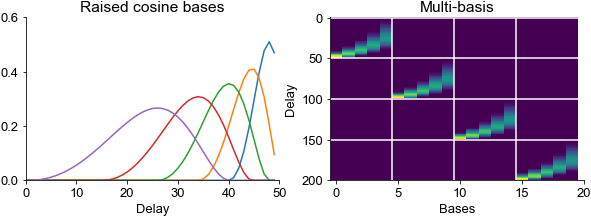

In [5]:
# define bases
B = raised_cosine(0, 5, [1, 23], 9, filter_duration)
B_multi = multifeature_basis(B, nb_stim)
basis_multi_projection = BasisProjection(B_multi)
_, nbases = B.shape

plt.figure(figsize = [10,3])
plt.subplot(121)
plt.plot(B)
plt.title('Raised cosine bases')
plt.xlabel('Delay')

plt.subplot(122)
plt.imshow(B_multi)
plt.hlines(np.arange(0, nb_stim*filter_duration,filter_duration), -0.5, B_multi.shape[1], colors='w')
plt.vlines(np.arange(0, nb_stim*nbases,nbases)-0.5, 0, B_multi.shape[0], colors='w')
plt.axis('tight')
plt.ylabel('Delay')
plt.xlabel('Bases')
plt.title('Multi-basis')
plt.show()

## Project

Next we will project our data to the basis function in the same way as before (see [basics](basics.ipynb)).

In [6]:
Xmulti_b = basis_multi_projection.transform(Xmulti)
print(f"Before [T, delays]: X {Xmulti.shape},  y {ymulti.shape}.")
print(f"After [T, bases]: X {Xmulti_b.shape},  y {ymulti.shape}.")

Before [T, delays]: X (99950, 200),  y (99950,).
After [T, bases]: X (99950, 20),  y (99950,).


## Split data into train and test set

As always, we will split our data into train and test sets (see [basics](basics.ipynb)). However, in comparison to our previous examples, we will split our indices, so that we can fairly compare the performance and results of different models.

In [7]:
# choose how many random samples to take from the data (less or equal than the available data, nb_points)
ntestsamples = int(ymulti.shape[0]/3)
test_idxs = np.random.choice(np.arange(ymulti.shape[0]),ntestsamples,replace=False)
train_idxs = np.squeeze(np.argwhere(~np.isin(np.arange(ymulti.shape[0]),test_idxs)))
print(f"test_idxs: {test_idxs.shape}, train_idxs: {train_idxs.shape}")


test_idxs: (33316,), train_idxs: (66634,)


## Fit a model

We can now fit a glm model using the training data and assess our model's performance.

In [9]:
lr = lm.LinearRegression()
lr.fit(Xmulti_b[train_idxs], ymulti[train_idxs])
print(f'score: {lr.score(Xmulti_b[test_idxs], ymulti[test_idxs]):1.2f}')

score: 1.00


# Filter reconstruction
To interpret the model we need to reconstruct the filters for each feature. If all features were normalized prior to fitting, then the filter magnitude (L2 norm) corresponds to the "importance" of each feature. The shape of the filters depicts how information from the features is integrated over time to produce the response.

The coefficients of our linear model, `lr.coef_`, correspond to weights for the different basis functions. We use the `inverse_transform` method of the `BasisProjection` class to reconstruct the filters from these weights (see [basics](basics.ipynb)). Since the model was fit with features that were concatenated, we "unconcatenate" the filters reshaping the resulting array.

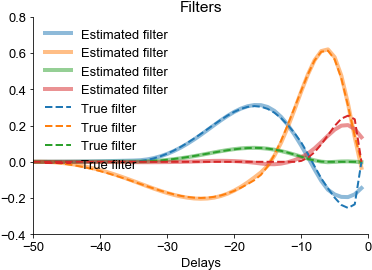

In [14]:
basis_weights = lr.coef_
estimated_filters = basis_multi_projection.inverse_transform(basis_weights)
estimated_filters = estimated_filters.reshape((-1,filter_duration))

plt.plot(T, estimated_filters.T, linewidth=4, alpha=0.5, label='Estimated filter')
plt.gca().set_prop_cycle(None)
plt.plot(T, filters, '--', linewidth=2, label='True filter')
plt.xlabel('Delays')
plt.title('Filters')
plt.legend(loc='upper left')
plt.show()

## Noise

Now, let's see what would happen if the responses are noisy. We can fit the model with different levels of noise added to the response, making the match between inputs and signal imperfect.

As you can see, the performance of the model decreases with the noise level, but the overall shape of the filters is relatively stable, even for the highest noise level.

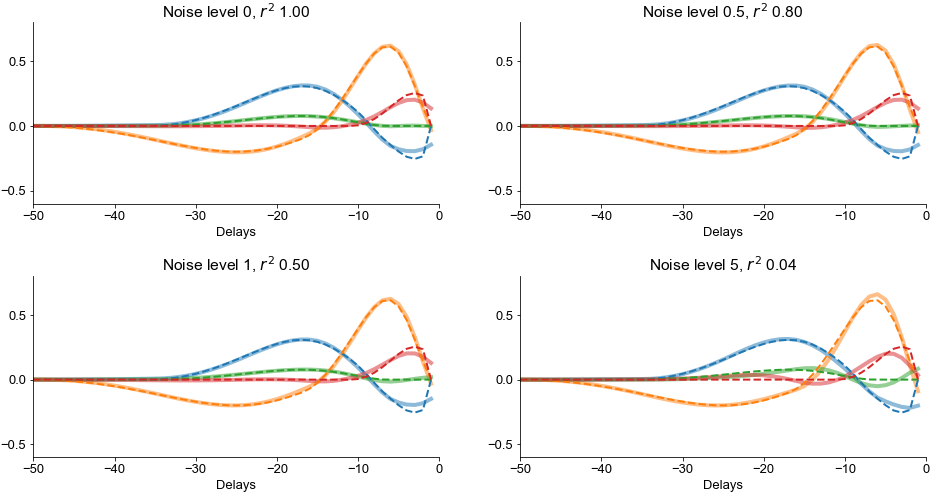

In [21]:
noise_levels = [0, 0.5, 1, 5]
plt.figure(figsize=(16, 8))
for jj, noise_level in enumerate(noise_levels):
    
    # add noise to the response
    y_noisy = ymulti + np.random.normal(ymulti.mean(), ymulti.std(), ymulti.shape[0])*noise_level

    # train
    lr = lm.LinearRegression()
    lr.fit(Xmulti_b[train_idxs], y_noisy[train_idxs])

    # reconstruct
    basis_weights = lr.coef_
    estimated_filters = basis_multi_projection.inverse_transform(basis_weights)
    estimated_filters = estimated_filters.reshape((-1,filter_duration))

    # plot
    plt.subplot(2, 2, jj+1)

    plt.plot(T, estimated_filters.T, linewidth=4, alpha=0.5, label='Estimated filter')
    plt.gca().set_prop_cycle(None)
    plt.plot(T, filters, '--', linewidth=2, label='True filter')
    plt.xlabel('Delays')
    plt.title(f'Noise level {noise_level}, $r^2$ {lr.score(Xmulti_b[test_idxs], y_noisy[test_idxs]):0.2f}')
    plt.ylim([-0.6, 0.8])
    if jj > 1:
        plt.xlabel('Delays')
plt.subplots_adjust(hspace=0.4)
plt.show()

## Missing features

What happens to the model performance and the filter shapes if we can't measure all relevant features? To emulate this, we will fit a model using only the first two features. Because we are modifying the number of inputs, we also need to create a new `multifeature_basis` and a new `BasisProjection`.

Omitting features reduces the model performance, but the filters for the remaining features are correctly reconstructed.



incomplete model score: 0.94


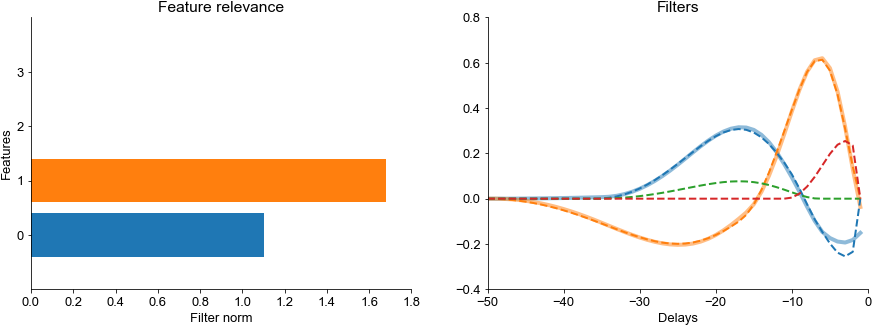

In [29]:
nb_stim_incomplete = 2

# bases
B_incomplete = multifeature_basis(B, nb_stim_incomplete)
basis_projection_incomplete = BasisProjection(B_incomplete)

# time-delay-embedding
X_incomplete, ymulti = time_delay_embedding(x[:, :2], y, window_size=filter_duration, flatten_inside_window=True)

# project
X_incomplete_b = basis_projection_incomplete.transform(X_incomplete)

# train
lr = lm.LinearRegression()
lr.fit(X_incomplete_b[train_idxs], ymulti[train_idxs])
print(f'incomplete model score: {lr.score(X_incomplete_b[test_idxs], ymulti[test_idxs]):1.2f}')

# reconstruct
basis_weights = lr.coef_
estimated_filters = basis_projection_incomplete.inverse_transform(basis_weights)
estimated_filters = estimated_filters.reshape((-1,filter_duration))

# filter norm
filt_norms = np.linalg.norm(estimated_filters, axis=1)

# plot
plt.figure(figsize=[15,5])
plt.subplot(121)
for ii in range(nb_stim_incomplete):
    plt.barh(ii, filt_norms[ii])
plt.xlabel('Filter norm')
plt.title('Feature relevance')
plt.ylabel('Features')
plt.yticks(np.arange(nb_stim),np.arange(nb_stim))
plt.ylim([-1,4])
plt.subplot(122)
plt.plot(T, estimated_filters.T, linewidth=4, alpha=0.5, label='Estimated filter')
plt.gca().set_prop_cycle(None)
plt.plot(T, filters, '--', linewidth=2, label='True filter')
plt.xlabel('Delays')
plt.title('Filters')
plt.show()

## Irrelevant features

Another common situation is providing the model with features that are not relevant for the response. In this example, our irrelevant feature will consist of a sample from a normal distribution, non-related with the signal. The model "recognizes" the new feature as irrelevant, and sets the coefficients and the filter for the irrelevant feature to zero. For real  data, even irrelevant features often have some correlation with relevant features, and even irrelevant features will get some weight in the model. Inspecting the norm and the shape of the filters should help spot those cases. Alternatively, you can use regularization, which suppresses contributions from unimportant features (see below and [basics.ipynb](basics.ipynb)).

irrelevant model score: 1.00


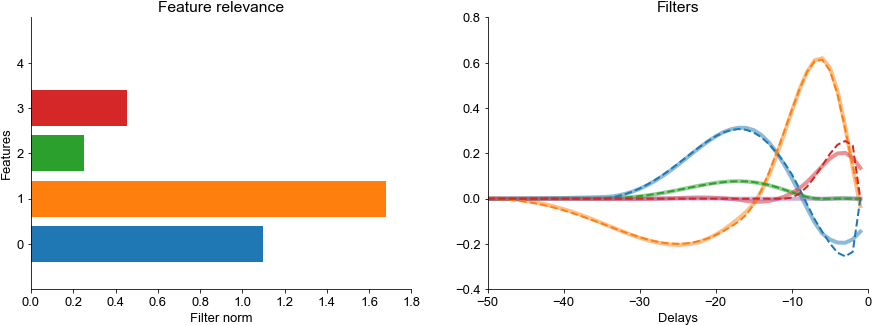

In [31]:
# data
x_irrelevant = np.concatenate((x,np.random.normal(0, 1, x[:,0].shape)[:,np.newaxis]),axis=1)

# bases
B_irrelevant = multifeature_basis(B, nb_stim+1)
basis_projection_irrelevant = BasisProjection(B_irrelevant)

# time-delay-embedding
X_irrelevant, ymulti = time_delay_embedding(x_irrelevant, y, window_size=filter_duration, flatten_inside_window=True)

# project
X_irrelevant_b = basis_projection_irrelevant.transform(X_irrelevant)

# train
lr = lm.LinearRegression()
lr.fit(X_irrelevant_b[train_idxs], ymulti[train_idxs])
print(f'irrelevant model score: {lr.score(X_irrelevant_b[test_idxs], ymulti[test_idxs]):1.2f}')

# reconstruct
basis_weights = lr.coef_
estimated_filters = basis_projection_irrelevant.inverse_transform(basis_weights)
estimated_filters = estimated_filters.reshape((-1,filter_duration))

# filter norm
filt_norms = np.linalg.norm(estimated_filters, axis=1)

# plot
plt.figure(figsize=[15,5])
plt.subplot(121)
for ii in range(nb_stim+1):
    plt.barh(ii,filt_norms[ii])
plt.xlabel('Filter norm')
plt.title('Feature relevance')
plt.ylabel('Features')
plt.yticks(np.arange(nb_stim+1),np.arange(nb_stim+1))
plt.subplot(122)
plt.plot(T, estimated_filters.T, linewidth=4, alpha=0.5, label='Estimated filter')
plt.gca().set_prop_cycle(None)
plt.plot(T, filters, '--', linewidth=2, label='True filter')
plt.xlabel('Delays')
plt.title('Filters')
plt.show()



# Single- vs. multi-feature models

All models so far were _multi-feature models_ - a model was fit with multiple features. An alternative approach is to fit and compare _single-feature models_ - one model per feature. To demonstrate the advantages of a multi-feature model, we will compare it to single-feature models.

In order to do this, let's continue using our previous example with an irrelevant feature. We already have the results for the multi-feature model, so let's save those for later.

In [12]:
# save previous results for comparison
integrated_model_filters = estimated_filters
integrated_model_score = lr.score(X_irrelevant_b[test_idxs], ymulti[test_idxs])

Now using the same steps as before - time delay embedding, basis projection, model fitting, scoring, and filter reconstruction - but using only one feature at a time, generating 5 single-feature models.

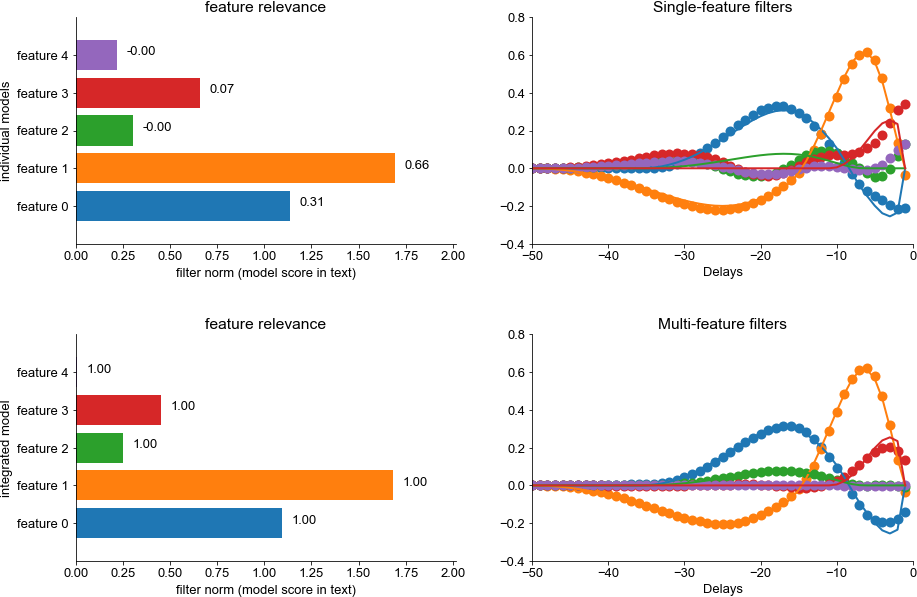

In [13]:
# indidivual basis
basis_projection = BasisProjection(B)

# lists to collect results per individual model
scores_list = []
estimated_filters_list = []

# loop through all the inputs
for ii in range(nb_stim+1):

    # time-delay-embedding
    Xs, ys = time_delay_embedding(x_irrelevant[:,ii], y, window_size=window_size, flatten_inside_window=True)

    # project
    Xs_b = basis_projection.transform(Xs)

    # train
    lr = lm.LinearRegression()
    lr.fit(Xs_b[train_idxs], ys[train_idxs])

    # reconstruct
    basis_weights = lr.coef_
    estimated_filters = basis_projection.inverse_transform(basis_weights)
    estimated_filters = estimated_filters.reshape((-1,window_size))

    # save results
    scores_list.append(lr.score(Xs_b[test_idxs], ys[test_idxs]))
    estimated_filters_list.append(np.squeeze(estimated_filters))


# plot
features_names = [f'feature {ii}' for ii in range(nb_stim+1)]
estimated_filters = np.asarray(estimated_filters_list)
filt_norms = np.linalg.norm(estimated_filters, axis=1)
int_filt_norms = np.linalg.norm(integrated_model_filters, axis=1)

plt.figure(figsize=[15,10])
plt.subplot(221)
for ii in range(nb_stim+1):
    plt.barh(ii,filt_norms[ii])
    plt.text(filt_norms[ii]+0.05, ii, s=f"{scores_list[ii]:0.2f}")
plt.yticks(np.arange(nb_stim+1),features_names)
plt.xlabel('filter norm (model score in text)')
plt.title('feature relevance')
plt.ylabel('individual models')
plt.xlim([0,np.max(int_filt_norms)*1.2])
plt.subplot(222)
for ii in range(nb_stim+1):
    plt.plot(T,estimated_filters_list[ii], 'o', linewidth=2, markersize=10)
plt.gca().set_prop_cycle(None)
plt.plot(T,filters, linewidth=2)
plt.xlabel('Delays')
plt.title('Single-feature filters')

plt.subplot(223)
for ii in range(nb_stim+1):
    plt.barh(ii,int_filt_norms[ii])
    plt.text(int_filt_norms[ii]+0.05, ii, s=f"{integrated_model_score:0.2f}")
plt.yticks(np.arange(nb_stim+1),features_names)
plt.xlabel('filter norm (model score in text)')
plt.title('feature relevance')
plt.ylabel('integrated model')
plt.xlim([0,np.max(int_filt_norms)*1.2])
plt.subplot(224)
plt.plot(T,integrated_model_filters.T, 'o', linewidth=2, markersize=10)
plt.gca().set_prop_cycle(None)
plt.plot(T,filters, linewidth=2)
plt.xlabel('Delays')
plt.title('Multi-feature filters')
plt.subplots_adjust(hspace=0.4)
plt.show()


You can see, the multi-feature model better "detects" the irrelevant feature - it sets the filter for that feature to zero. By contrast, the single-feature model for the multi feature model produces a zero score but  a non-zero filter.'

# Redundant features

In the next example we will demonstrate what happens in the presence of redundant (a.k.a. colinear) features. In this example the redundant feature is constructed by adding two of our previous features - the new feature 4 is partly redundant with features 1 and 2.

We will introduce a new type of model in this example, called Lasso. The LASSO minimizes the number of non-zero coefficients while maximizing the model performance through a process called _regularization_. In a way, this is Occam's razor applied to generalized linear models. 

Regularization successfully reduces the weights for redundant features. However, the magnitudes and shapes of the remaining filters are also slightly distorted  in the process. The correct level of regularization should be determined using crossvalidation.

Standard linear regression, model score: 1.00
LASSO, model score: 0.96


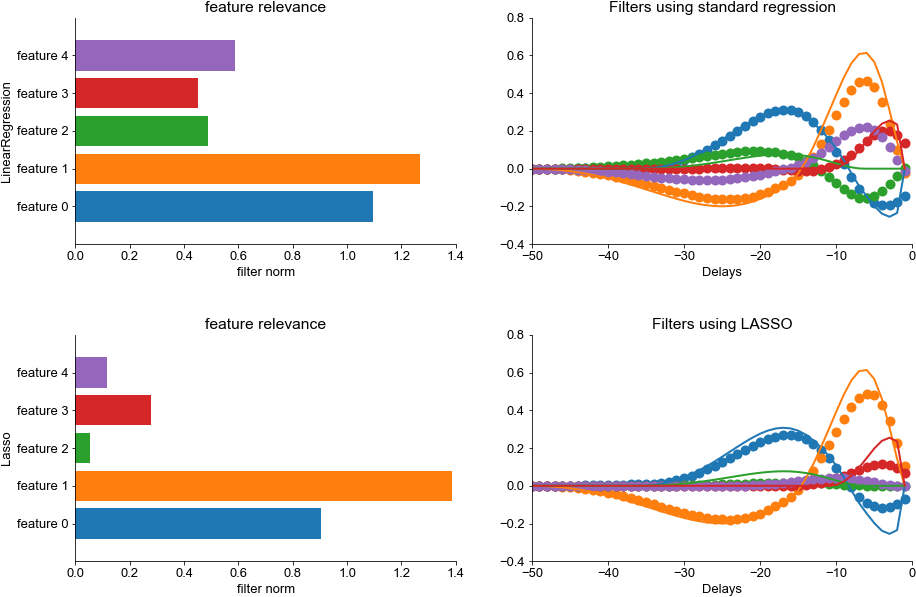

In [14]:
# data
x_redundant = np.concatenate((x,x[:,[1]]+x[:,[2]]),axis=1)
x_redundant[:,-1] = (x_redundant[:,-1] - np.mean(x_redundant[:,-1]))/np.std(x_redundant[:,-1]) # normalize new feature

# bases
B_redundant = multifeature_basis(B, nb_stim+1)  # should explain what/why we do this here
basis_projection_redundant = BasisProjection(B_redundant)  # should explain what/why we do this here

# time-delay-embedding
X_redundant, ymulti = time_delay_embedding(x_redundant, y, window_size=window_size, flatten_inside_window=True)

# project
X_redundant_b = basis_projection_redundant.transform(X_redundant)

# train
lr = lm.LinearRegression()
lr.fit(X_redundant_b[train_idxs], ymulti[train_idxs])
print(f'Standard linear regression, model score: {lr.score(X_redundant_b[test_idxs], ymulti[test_idxs]):1.2f}')

# train (with lasso)
lr_lasso = lm.Lasso()
lr_lasso.fit(X_redundant_b[train_idxs], ymulti[train_idxs])
print(f'LASSO, model score: {lr_lasso.score(X_redundant_b[test_idxs], ymulti[test_idxs]):1.2f}')

# reconstruct
basis_weights = lr.coef_
estimated_filters = basis_projection_redundant.inverse_transform(basis_weights)
estimated_filters = estimated_filters.reshape((-1,window_size))

# reconstruct (with lasso)
basis_weights_lasso = lr_lasso.coef_
estimated_filters_lasso = basis_projection_redundant.inverse_transform(basis_weights_lasso)
estimated_filters_lasso = estimated_filters_lasso.reshape((-1,window_size))

# relevance plot for lr
features_names = [f'feature {ii}' for ii in range(nb_stim+1)]
plt.figure(figsize=[15,10])
plt.subplot(221)
for ii in range(nb_stim+1):
    filt_norm = np.linalg.norm(estimated_filters[ii])
    plt.barh(ii, filt_norm)
plt.yticks(np.arange(nb_stim+1),features_names)
plt.xlabel('filter norm')
plt.title('feature relevance')
plt.ylabel('LinearRegression')
plt.subplot(222)
plt.plot(T,estimated_filters.T, 'o', linewidth=2, markersize=10)
plt.gca().set_prop_cycle(None)
plt.plot(T,filters, linewidth=2)
plt.xlabel('Delays')
plt.title('Filters using standard regression')

# relevance plot for lasso
plt.subplot(223)
for ii in range(nb_stim+1):
    filt_norm = np.linalg.norm(estimated_filters_lasso[ii])
    plt.barh(ii,filt_norm)
plt.yticks(np.arange(nb_stim+1),features_names)
plt.xlabel('filter norm')
plt.title('feature relevance')
plt.ylabel('Lasso')
plt.subplot(224)
plt.plot(T,estimated_filters_lasso.T, 'o', linewidth=2, markersize=10)
plt.gca().set_prop_cycle(None)
plt.plot(T,filters, linewidth=2)
plt.xlabel('Delays')
plt.title('Filters using LASSO')
plt.subplots_adjust(hspace=0.4,wspace=0.2)
plt.show()